# Layer wise relevance propagation for all_model

Source:  
https://github.com/seongun-kim/1210_dtd_ig/blob/master/methods/deep_taylor_decomposition.py

The backpropagation rule:   
∀k : sk = Rk/zk (element-wise division)  
for the convolutional layer is violated due to matrix dimension incompatibility.  
Therefore, the influence on the relevance of this layer is neglected.  
More information in the book:  
Explainable AI: Interpreting, Explaining and Visualizing Deep Learning, page 197 by Wojciech Samek, Grégoire Montavon, Andrea Vedaldi, Lars Kai Hansen, Klaus-Robert Müller (Eds.).

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.model_selection import train_test_split

import keras

import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
def set_reproducible():
    np.random.seed(12345)
    random.seed(12345)
    tf.random.set_seed(12345)
    
set_reproducible()

In [3]:
dps1200 = pd.read_csv("/home/mel/Masterthesis/Masterthesis_code/raw_data/csv/dps1200_all.csv")

In [4]:
dps1200.rename(columns=lambda x: x.replace('X', ''), inplace=True)

In [5]:
features = dps1200.iloc[:, 4:].values
labels = dps1200.iloc[:, 0].values

In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

In [7]:
model_path = "/home/mel/Masterthesis/Masterthesis_code/code/all_data/dps1200all_model.keras"

In [8]:
dps1200all_model = tf.keras.models.load_model(model_path)

# Show the model architecture
dps1200all_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 1866, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1833, 24)       │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 916, 24)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 820, 52)        │       121,108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 410, 52)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21320)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21320)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 422)            │     8,997,462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           423 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,501 (104.37 MB)

 Trainable params: 9,119,833 (34.79 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,239,668 (69.58 MB)

# LRP

In [9]:
for i, layer in enumerate(dps1200all_model.layers):
    print(f"Layer {i+1}: {layer.name}")
    if hasattr(layer, 'weights') and layer.weights:
        weights, biases = layer.get_weights()
        print(f"Weights shape: {weights.shape}")
        print(f"Biases shape: {biases.shape}")
    else:
        print("No weights in this layer.")


Layer 1: gaussian_noise
No weights in this layer.
Layer 2: conv1d
Weights shape: (34, 1, 24)
Biases shape: (24,)
Layer 3: max_pooling1d
No weights in this layer.
Layer 4: conv1d_1
Weights shape: (97, 24, 52)
Biases shape: (52,)
Layer 5: max_pooling1d_1
No weights in this layer.
Layer 6: flatten
No weights in this layer.
Layer 7: dropout
No weights in this layer.
Layer 8: dense
Weights shape: (21320, 422)
Biases shape: (422,)
Layer 9: dense_1
Weights shape: (422, 1)
Biases shape: (1,)


In [10]:
print(dps1200all_model.inputs[0])

<KerasTensor shape=(None, 1866, 1), dtype=float32, sparse=False, name=input_layer>


In [37]:
class DTD:
    def __init__(self, sess, dataset, model):
        # Tensorflow session.
        self.sess = sess
        # Dataset.
        self.ds = dataset
        self.model = model

        def get_all_activations(model, input_data):
            
            all_activations = []
            for layer in model.layers:
                
                intermediate_layer_model = tf.keras.Model(inputs=model.inputs,
                                                        outputs=layer.output)
                layer_activations = intermediate_layer_model.predict(input_data)
                all_activations.append(layer_activations)
        
            return all_activations
    
    # Load model parameter for explanation.
        self.X = model.inputs
        self.pred = model.outputs        
        self.conv_w_1 = model.layers[1]
        self.conv_w_2 = model.layers[3]
        self.fc_w_1 =  model.layers[7]
        self.fc_w_2 = model.layers[8]
        self.activations = get_all_activations(model, dataset)
        
    
    def backprop_dense_z_plus(self, activation, layer : keras.layers.Dense, relevance):
        kernel = layer.kernel.numpy()
        W_p = np.maximum(np.zeros_like(kernel), kernel)
        z = np.matmul(activation, W_p) + 1e-9
        s = relevance / z
        c = np.matmul(s, np.transpose(W_p))
        return activation * c

    
    def simple_backprop(self, activation, layer : keras.layers.Conv1D, relevance, padding='valid'):
        kernel = layer.kernel.numpy()
        W_p = np.maximum(np.zeros_like(kernel), kernel)
        c = keras.ops.conv_transpose(relevance, W_p, [1], padding=padding)
        return c
    
    
    def backprop_y_pooling_2(self, prev_activation : np.array, relevance : np.array):
        result_relevance = np.zeros_like(prev_activation)

        for x in range(relevance.shape[0]):
            for y in range(relevance.shape[1]):
                for z in range(relevance.shape[2]):
                    left = prev_activation[x,y*2,z]
                    right = prev_activation[x,y*2+1,z]

                    if left > right:
                        result_relevance[x,y*2,z] = relevance[x,y,z]
                    elif left < right:
                        result_relevance[x,y*2+1,z] = relevance[x,y,z]
                    else:
                        result_relevance[x,y*2+1,z] = relevance[x,y,z]
                        result_relevance[x,y*2,z] = relevance[x,y,z]
        
        return result_relevance


    def run(self):
        # Initialize a list of relevance.
        Rs = []

        # Assign relevance to the output.
        relevance = self.activations[-1]
        Rs.append(relevance)
        
        # fc_layer_2
        relevance = self.backprop_dense_z_plus(self.activations[-2], self.fc_w_2, Rs[-1])
        Rs.append(relevance)
        
        # fc_layer_1
        relevance = self.backprop_dense_z_plus(self.activations[-3], self.fc_w_1, Rs[-2])
        Rs.append(relevance)

        #omit dropout layer
        Rs.append(relevance)
        
        # Flatten
        relevance = np.reshape(Rs[-1], self.activations[4].shape)
        Rs.append(relevance)

        # Pooling
        relevance = self.backprop_y_pooling_2(self.activations[3], Rs[-1])
        Rs.append(relevance)
        
        # conv_2
        relevance = self.simple_backprop(self.activations[3], self.conv_w_2, Rs[-1])
        Rs.append(relevance)

        # Pooling
        relevance = self.backprop_y_pooling_2(self.activations[1], Rs[-1])
        Rs.append(relevance)
        
        # conv_1
        relevance = self.simple_backprop(self.activations[1], self.conv_w_1, Rs[-1])
        Rs.append(relevance)

        return Rs

In [38]:
back = DTD(dps1200all_model, test_data, dps1200all_model)
rel = back.run()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


In [44]:
print(rel[-1])
rele = keras.ops.convert_to_numpy(rel[-1])
rele = np.max(rele, 2)
print(rele.shape)

tf.Tensor(
[[[17.091988 ]
  [24.747875 ]
  [35.964676 ]
  ...
  [13.993285 ]
  [ 6.914185 ]
  [ 0.       ]]

 [[27.775137 ]
  [47.319504 ]
  [68.16571  ]
  ...
  [ 7.7808833]
  [ 5.089961 ]
  [ 0.       ]]

 [[28.255959 ]
  [47.98108  ]
  [70.52337  ]
  ...
  [ 6.534355 ]
  [ 4.782347 ]
  [ 0.       ]]

 ...

 [[26.084793 ]
  [44.561455 ]
  [65.25043  ]
  ...
  [ 6.8050957]
  [ 4.645744 ]
  [ 0.       ]]

 [[20.962284 ]
  [35.634773 ]
  [52.011765 ]
  ...
  [13.245576 ]
  [ 6.8296833]
  [ 0.       ]]

 [[15.3839445]
  [26.572933 ]
  [39.542137 ]
  ...
  [11.94616  ]
  [ 5.7904315]
  [ 0.       ]]], shape=(260, 1866, 1), dtype=float32)
(260, 1866)


In [41]:
import seaborn as sns

In [42]:
y = dps1200.iloc[:,4:]
xp = y.columns.values
xp = xp.astype(int)

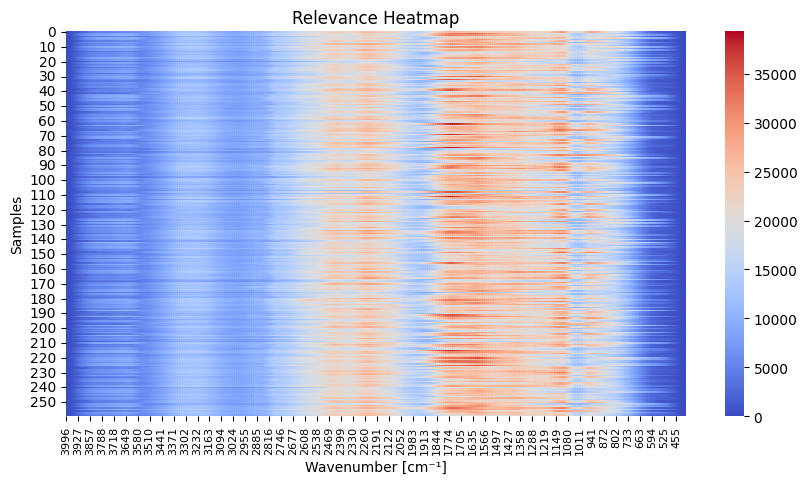

In [ ]:
# Plot Heatmap
wavelengths = xp[::36]

# Plot Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(rele, cmap='coolwarm')
plt.xlabel('Wavenumber [cm⁻¹]')
plt.ylabel('Samples')
plt.title('Relevance Heatmap')
plt.xticks(ticks=np.arange(0.5, rele.shape[1] + 0.5, 36), labels=wavelengths, fontsize=8)
plt.show()

# Heatmap with sorted data according to the years

In [47]:
test_labels_2d = test_labels.reshape(-1, 1)
test_data_all = np.concatenate((test_labels_2d, rele), axis=1)


sorted_indices = np.argsort(test_data_all[:, 0])
test_all_sorted = test_data_all[sorted_indices]

sorted_test_labels = test_all_sorted[:, 0]
sorted_rele_data = test_all_sorted[:, 1:]

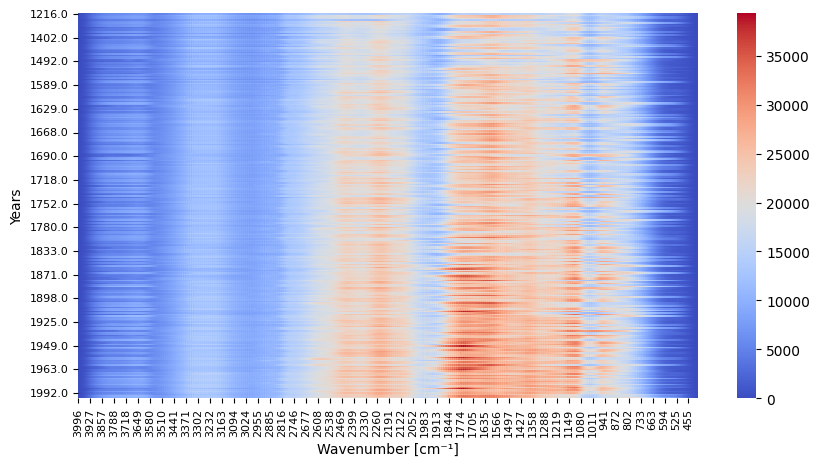

In [ ]:
# Plot Heatmap
wavelengths = xp[::36]

years = sorted_test_labels[::16]

# Plot Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(sorted_rele_data, cmap='coolwarm')
plt.xlabel('Wavenumber [cm⁻¹]')
plt.ylabel('Years')
#plt.title('Relevance Heatmap')
plt.xticks(ticks=np.arange(0.5, rele.shape[1] + 0.5, 36), labels=wavelengths, fontsize=8)
plt.yticks(ticks=np.arange(0.5, rele.shape[0] + 0.5, 16), labels=years, fontsize=8)
plt.show()